# RL for HVAC control with BOPTEST

For this project we are going to train RL agents to control the HVAC system of buildings. We are going to use the Buildnig Optimization Performance Test (BOPTEST) framework to simulate the building and the HVAC system and its gym environment to train the agents.

[BOPTEST](https://ibpsa.github.io/project1-boptest/software/) is a framework that enables evaluation and benchmarking of control algorithms for building HVAC control through simulations. In order to run the simulations we will use the [BOPTEST service](https://github.com/NREL/boptest-service) which is a webservice wrapping the simulation framework. We can use the public instance available at `https://api.boptest.net` (which would be very slow for RL training) or we can host our own one easily with docker by following the instructions on the repo's [`README.md`](https://github.com/NREL/boptest-service?tab=readme-ov-file#building-and-running-on-a-personal-computer)

## 1. Testing the BOPTEST web service

Let's start by testing our local BOPTEST service instance. API documentation can be found [here](https://ibpsa.github.io/project1-boptest/docs-userguide/api.html).

A test case has to be chosen from the [BOPTEST test cases](https://ibpsa.github.io/project1-boptest/testcases/index.html).

In [1]:
import requests
url = 'http://localhost'
testcase = 'bestest_air'

testid = requests.post('{0}/testcases/{1}/select'.format(url,testcase)).json()['testid']

name = requests.get('{0}/name/{1}'.format(url, testid)).json()['payload']
print('Testcase name: ', name, '\n')

inputs = requests.get('{0}/inputs/{1}'.format(url, testid)).json()['payload']
print('Available inputs: ', inputs.keys(), "\n")

measurements = requests.get('{0}/measurements/{1}'.format(url, testid)).json()['payload']
print('Available measurements: ', measurements.keys(), "\n")

forecast_points = requests.get('{0}/forecast_points/{1}'.format(url, testid)).json()['payload']
print('Available forecast points: ', forecast_points.keys(), "\n")

requests.put('{0}/stop/{1}'.format(url, testid))

Testcase name:  {'name': 'bestest_air'} 

Available inputs:  dict_keys(['con_oveTSetCoo_activate', 'con_oveTSetCoo_u', 'con_oveTSetHea_activate', 'con_oveTSetHea_u', 'fcu_oveFan_activate', 'fcu_oveFan_u', 'fcu_oveTSup_activate', 'fcu_oveTSup_u']) 

Available measurements:  dict_keys(['fcu_reaFloSup_y', 'fcu_reaPCoo_y', 'fcu_reaPFan_y', 'fcu_reaPHea_y', 'zon_reaCO2RooAir_y', 'zon_reaPLig_y', 'zon_reaPPlu_y', 'zon_reaTRooAir_y', 'zon_weaSta_reaWeaCeiHei_y', 'zon_weaSta_reaWeaCloTim_y', 'zon_weaSta_reaWeaHDifHor_y', 'zon_weaSta_reaWeaHDirNor_y', 'zon_weaSta_reaWeaHGloHor_y', 'zon_weaSta_reaWeaHHorIR_y', 'zon_weaSta_reaWeaLat_y', 'zon_weaSta_reaWeaLon_y', 'zon_weaSta_reaWeaNOpa_y', 'zon_weaSta_reaWeaNTot_y', 'zon_weaSta_reaWeaPAtm_y', 'zon_weaSta_reaWeaRelHum_y', 'zon_weaSta_reaWeaSolAlt_y', 'zon_weaSta_reaWeaSolDec_y', 'zon_weaSta_reaWeaSolHouAng_y', 'zon_weaSta_reaWeaSolTim_y', 'zon_weaSta_reaWeaSolZen_y', 'zon_weaSta_reaWeaTBlaSky_y', 'zon_weaSta_reaWeaTDewPoi_y', 'zon_weaSta_reaWeaTDry

<Response [200]>

## 2. Understaing the test case

We'll be working with the `bestest_air` test case. Detailed documentation can be found [here](https://ibpsa.github.io/project1-boptest/docs-testcases/bestest_air/index.html). The provided description is:

> The building is a single room. The floor dimensions are 6m x 8m and the floor-to-ceiling height is 2.7m. There are four exterior walls facing the cardinal directions and a flat roof. The walls facing east-west have the short dimension. The south wall contains two windows, each 3m wide and 2m tall. The use of the building is assumed to be a two-person office with a light load density.     

We also know that the the climate is assumed to be near Denver, CO, USA and that the heating and cooling setpoint follow a schedule. Being it more strict from 8am to 6pm and more relaxed the rest of the time.

Regarding the HVAC system, there is a fan, a cooling coil, a heating coil, and filter. The fan draws room air into the unit, blows it over the coils and through the filter, and supplies the conditioned air back to the room. There is a variable speed drive serving the fan motor. The cooling coil is served by chilled water produced by a chiller and the heating coil is served by hot water produced by a gas boiler. Below is a schematic of the system.

![HVAC system schematic](images/hvac-schematic-bestest-air.png)

As we already saw from the tests with the API and the documentation, we have a list of available inputs which will be the actions our agent can take. We also have the observations, which are going to be what the agent will use to learn the best actions to take. The observations are both the measurements (the state of the building) and the forecast points (exogenous variables)

> **Exogenous**: Originating or produced from outside a cell, tissue, or organism. *In this case, that it is not affected by the actions taken by the agent i.e. the solar radiation.*

The documentation provides a description for each of the available inputs and observations. We'll start focusing on only a few of them to simplify the problem. 

#### Inputs:

- `fcu_oveTSup_u` [K] [min=285.15, max=313.15]: Supply air temperature setpoint 

#### Outputs:

- `zon_reaTRooAir_y` [K] [min=None, max=None]: Zone air temperature 

Notice that ovbsevations don't have a default min and max values while the inputs do. The user is responsible for choosing the range of values for the observations. We are going to use 318K for the max which is about 45°C and 273K for the min which is equivalent to 0°C.

## 3. Set up the gym environment

Import the [gym environment](https://github.com/ibpsa/project1-boptest-gym) develpoed by the BOPTEST team and make some adjustments for plotting and logging.

In [2]:
import os

if not os.path.exists("boptestGymService"):
    !git clone -b boptest-gym-service https://github.com/ibpsa/project1-boptest-gym.git boptestGymService
    !cp boptest-gym.patch boptestGymService && cd boptestGymService && git am boptest-gym.patch
else:
    print("Folder 'boptestGymService' already exists. Skipping clone.")

import sys
sys.path.insert(0,'boptestGymService')
from boptestGymEnv import BoptestGymEnv

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message="FigureCanvasAgg is non-interactive, and thus cannot be shown")
warnings.simplefilter(action='ignore', category=FutureWarning)

def deactivate_plots():
    matplotlib.use('Agg')

def activate_plots():
    plt.ioff()
    %matplotlib inline

Folder 'boptestGymService' already exists. Skipping clone.


To keep it simple for now we are going to only aim for keeping the user discomfort as low as possible (which means to keep the zone temperature on the desired range) and we are not going to care about energy consumption. The KPIs that BOPTEST provides are, as described in the [API documentation](https://ibpsa.github.io/project1-boptest/docs-userguide/api.html#get-kpi):

```json
    "cost_tot":<value>,     // float, HVAC energy cost in $/m2 or Euro/m2
    "emis_tot":<value>,     // float, HVAC energy emissions in kgCO2e/m2
    "ener_tot":<value>,     // float, HVAC energy total in kWh/m2
    "pele_tot":<value>,     // float, HVAC peak electrical demand in kW/m2
    "pgas_tot":<value>,     // float, HVAC peak gas demand in kW/m2
    "pdih_tot":<value>,     // float, HVAC peak district heating demand in kW/m2
    "idis_tot":<value>,     // float, Indoor air quality discomfort in ppmh/zone
    "tdis_tot":<value>,     // float, Thermal discomfort in Kh/zone
    "time_rat":<value>      // float, Computational time ratio in s/ss
```

For the reward computation we are going to use `tdis_tot`, since as described in the [BOPTEST paper](https://doi.org/10.1080/19401493.2021.1986574) at section 3.4.1: *thermal discomfort defines the cumulative deviation of zone temperatures from upper and lower comfort limits that are predefined within the test case*.

Although by now we are only interested in minimizing the thermal discomfort, we are also going to keep track of energy consumption since it is an important factor in real-world applications. For this reason the following helper function is defined, which will be used to plot the values of the KPIs during the different training episodes.


In [3]:
def plot_kpis_with_trend(df: pd.DataFrame, days_between_xticks: int = 5, poly_degree: int = 5):
    """
    Plot the accumulated values at the end of each episode for thermal 
    discomfort and energy consumption KPIs with trend lines.
    """
    fig, ax1 = plt.subplots(figsize=(12, 6))

    l1, = ax1.plot(df.index, df['tdis_tot'], color='darkcyan', alpha=0.4, linestyle='solid', label='Thermal discomfort (raw)')
    ax1.set_xlabel('Episodes (Days)')
    ax1.set_xticks(df.index[::days_between_xticks])
    ax1.grid(alpha=0.6)

    poly_tdis = np.poly1d(np.polyfit(df.index, df['tdis_tot'], poly_degree))
    l2, = ax1.plot(df.index, poly_tdis(df.index), color='darkcyan', linewidth=2, linestyle='dashed', label='Thermal discomfort (trend)')

    ax2 = ax1.twinx()
    l3, = ax2.plot(df.index, df['ener_tot'], color='salmon', alpha=0.4, linestyle='solid', label='Energy consumption (raw)')

    poly_ener = np.poly1d(np.polyfit(df.index, df['ener_tot'], poly_degree))
    l4, = ax2.plot(df.index, poly_ener(df.index), color='salmon', linewidth=2, linestyle='dashed', label='Energy consumption (trend)')

    lines = [l1, l2, l3, l4]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper right')

    plt.title('Thermal discomfort and energy consumption during training episodes')
    plt.show()

To understand how to define a custom reward function it is useful to look at the default implementation of `get_reward` in the `BoptestGymEnv` class. 

In [4]:
class BoptestGymEnvSimpleDiscomfort(BoptestGymEnv):
    
    def get_reward(self):
        kpis = requests.get('{0}/kpi/{1}'.format(self.url,self.testid)).json()['payload']
        self.kpis.append(kpis)

        objective_integrand = kpis['tdis_tot']
        reward = -(objective_integrand - self.objective_integrand)
        
        self.objective_integrand = objective_integrand
        
        return reward

We need to define some time related parameters before creating the gym env.

- `step_period` [int]: Number of seconds between each step. We are going to use 900 seconds (15 minutes).
- `predictive_period` [int]: Defined the number of steps to predict ahead. This means we will obtain the predicted value for each of the chosen observations for the next `predictive_period` steps. We are going to use 3600 seconds (1 hour or 4 steps).
- `regressive_period` [int]: Defined the number of steps to predict back. The same as `predictive_period` but for the past. We are going to use 3600 seconds (1 hour or 4 steps).
- `max_episode_length` [int]: Maximum number of seconds in an episode. Defines the size of each episode. We are going to use 24 * 3600 seconds (1 day).
- `warmup_period` [int]: How much time do we want the simulation to run before starting the episode. Needs to be at least `regressive_period`. We are going to use 24 * 3600 seconds (1 day).
- `random_start_time` [bool]: If we want to start each episode at a random time. We are going to use `True`.


And for the model, we'll go with [Stable Baselines3](htt) `DQN` agent with `MLP` policy. 

In [35]:
from boptestGymEnv import BoptestGymEnv, NormalizedObservationWrapper, DiscretizedActionWrapper
from stable_baselines3 import DQN

env = BoptestGymEnvSimpleDiscomfort(url                  = 'http://localhost',
                    testcase             = 'bestest_air',
                    actions              = ['fcu_oveTSup_u'],
                    observations         = {'zon_reaTRooAir_y':(273.,318.)},
                    predictive_period    = 3600,
                    regressive_period    = 3600,
                    random_start_time    = True,
                    max_episode_length   = 24*3600,
                    warmup_period        = 24*3600,
                    step_period          = 900,
                    render_episodes      = True)

env = NormalizedObservationWrapper(env)
env = DiscretizedActionWrapper(env,n_bins_act=20)

model = DQN('MlpPolicy', env, seed=1234, learning_rate=5e-4, batch_size=24, 
            buffer_size=365*24, learning_starts=24, train_freq=1)


/home/ferran/projects/carles-mateu/a2/.venv/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


<Figure size 640x480 with 0 Axes>

Notice a couple wrappers from BOPTEST-gym were used. `DiscretizedActionArapper` is needed since the `DQN` agent expects action space to be discretized and not continuous. `NormalizedObservationWrapper` is used to normalize the observations for faster convergence.

# 4. Training the agent

We'll first train the model for an single episode (1 day) and see how does it perform. Our step size is 15 minutes so we have 96 steps in a day.

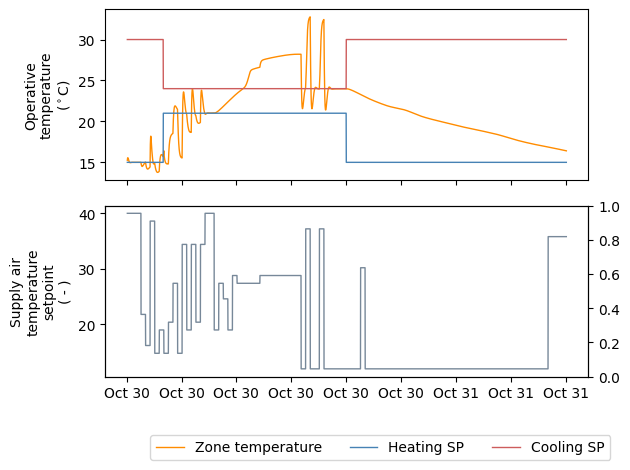

In [36]:
model.learn(total_timesteps=96)

It performs bad, as expected, but we can see the agent is indeed exploring its action space. Let's now train it for 75 days and see how it performs.

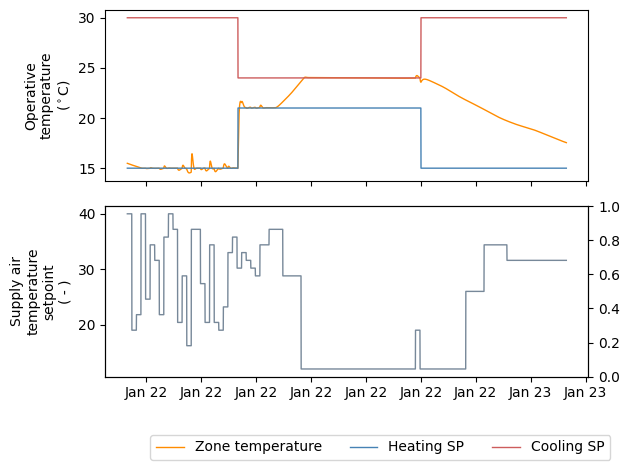

In [37]:
deactivate_plots()
model.learn(total_timesteps=96 * 75)
activate_plots()

# Train for one more day with visualizations enabled
model.learn(total_timesteps=96)

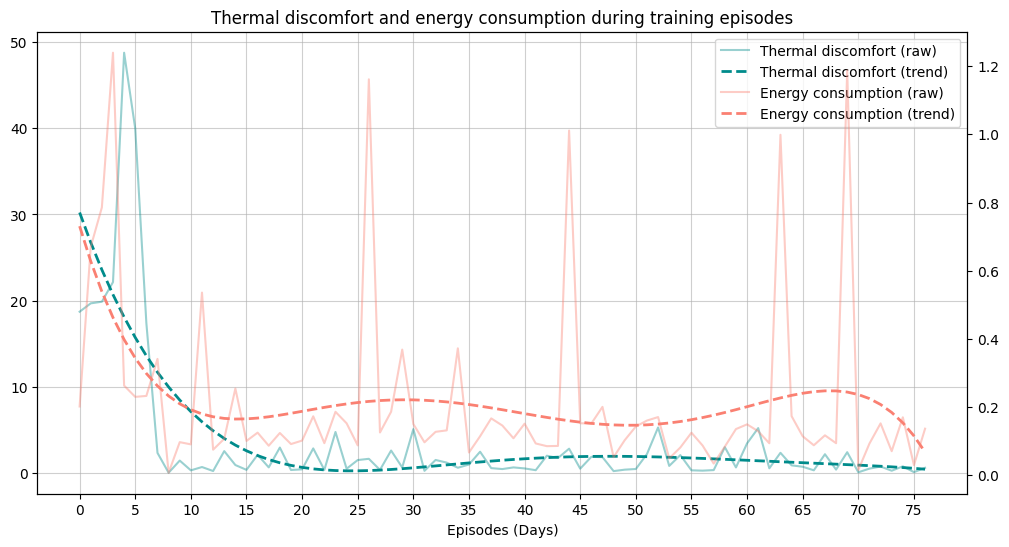

In [38]:
env1_df = pd.DataFrame(env.episode_kpis)
plot_kpis_with_trend(env1_df)

In [9]:
env.stop()

The agent seems to have learned how to keep the thermal discomfort low, but remember that is the only thing it is trying to optimize, so if we take a look at how do the KPIs look during each episode we can see that while energy consumption `ener_tot` doesn't show much improvement (as expected), the thermal discomfort `tdis_tot` goes down as the agent learns, although it seems to stop improving around 20 days.

# 5. Stepping things up

In HVAC control it is a must to maintain the thermal comfort of the occupants, but it is also key to keep the energy consumption low. We are going to modify the reward function to take into account both the thermal discomfort and the energy consumption.

In [10]:
class BoptestGymEnvWeighted(BoptestGymEnv):
    
    def get_reward(self):
        kpis = requests.get('{0}/kpi/{1}'.format(self.url,self.testid)).json()['payload']
        self.kpis.append(kpis)
        
        objective_integrand = kpis['ener_tot'] + kpis['tdis_tot']
        reward = -(objective_integrand - self.objective_integrand)
        self.objective_integrand = objective_integrand

        return reward

This time we are going let the model take one more action and we'll add more observations.

#### New inputs:

- `fcu_oveFan_u` [1] [min=0.0, max=1.0]: Fan control signal as air mass flow rate normalized to the design air mass flow rate 

#### New outputs:

- `TDryBul` [K]: Dry bulb temperature at ground level 
- `HDirNor` [W/m2]: Direct normal radiation 
- `LowerSetp[1]` [K]: Lower temperature set point for thermal comfort of zone 
- `UpperSetp[1]` [K]: Upper temperature set point for thermal comfort of zone 


In [11]:
env = BoptestGymEnvWeighted(url                  = 'http://localhost',
                    testcase             = 'bestest_air',
                    actions              = ['fcu_oveTSup_u', 'fcu_oveFan_u'],
                    observations         = {
                                            'zon_reaTRooAir_y':(273.,318.),
                                            'TDryBul':(265,303),
                                            'HDirNor':(0,862),
                                            'LowerSetp[1]':(273.,318.),
                                            'UpperSetp[1]':(273.,318.)
                                            },
                    predictive_period    = 3600,
                    regressive_period    = 3600,
                    random_start_time    = True,
                    max_episode_length   = 24*3600,
                    warmup_period        = 24*3600,
                    step_period          = 900,
                    render_episodes      = True)

env = NormalizedObservationWrapper(env)
env = DiscretizedActionWrapper(env,n_bins_act=20)

model = DQN('MlpPolicy', env, seed=1234, learning_rate=5e-4, batch_size=24, 
            buffer_size=365*24, learning_starts=24, train_freq=1)


/home/ferran/projects/carles-mateu/a2/.venv/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


<Figure size 640x480 with 0 Axes>

Let's now train first for a single day as before and then for 2 years since we expect this model to take longer to learn.

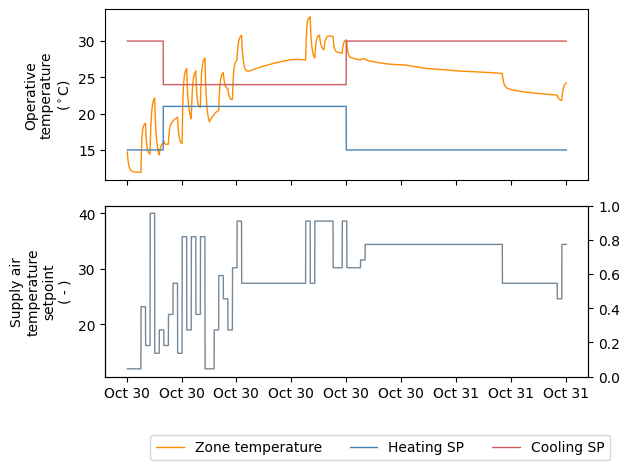

In [12]:
model.learn(total_timesteps=96)

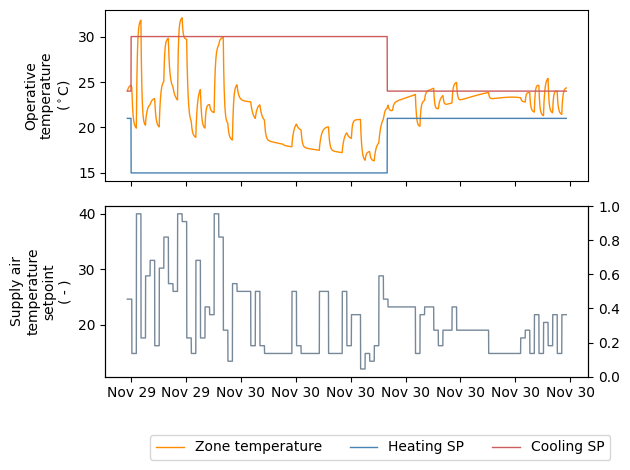

In [13]:
deactivate_plots()
model.learn(total_timesteps=96 * 365 * 2)
activate_plots()

# Train for one more day with visualizations enabled
model.learn(total_timesteps=96)

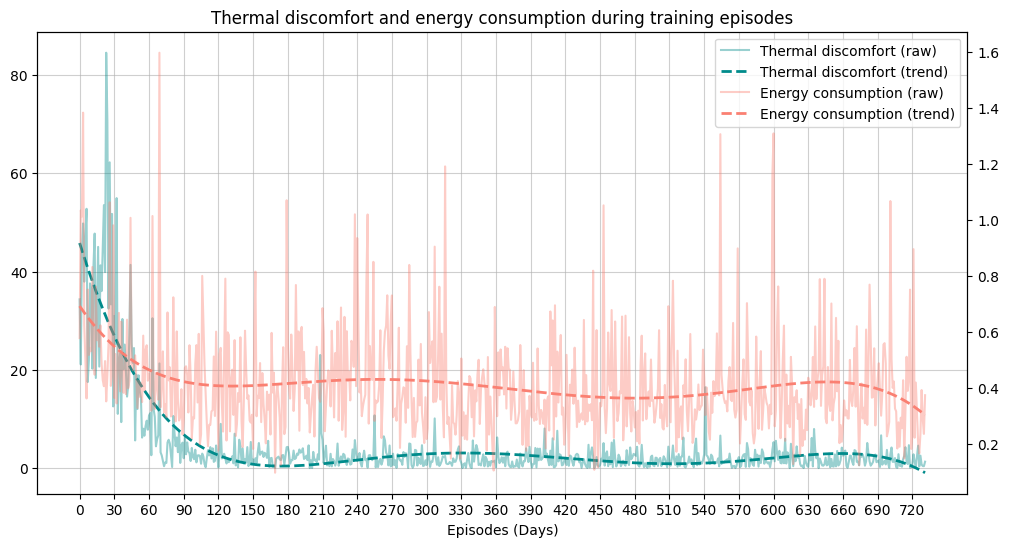

In [31]:
env2_df = pd.DataFrame(env.episode_kpis)
plot_kpis_with_trend(env2_df, days_between_xticks=30, poly_degree=5)

In [34]:
env.stop()

Surprisingly, we see that both energy usage and thermal comfort end up at similar levels as before. It may be due to the model sticking to the heating setpoint in order to maintain thermal comfort and as a consequence the energy usage is also reduced when only optimizing for thermal comfort. This time it took way longer which makes sense since we are working with more observations than before and the actions space is bigger. Improvement seems to stop after around 150 days.